# [E-03]This_is_your_playground_Leaderboard  


## 1) 라이브러리 버전을 확인해 봅니다  


In [205]:
import xgboost
import lightgbm
import missingno
import sklearn

print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

1.7.1
3.3.3
0.5.1
1.1.3


### Import

In [206]:
import os
import pandas as pd
import numpy as np
import missingno as msno # 결측값 확인 라이브러리

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # MSE 계산식
from xgboost import XGBRegressor #xgboost 모델
from lightgbm import LGBMRegressor #lightgbm 모델
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor #gradienboost, randomforest 모델
from sklearn.model_selection import GridSearchCV #그리드

import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 Read

In [207]:
price_path = os.getenv('homepath') + '/Desktop/python/exploration/exploration_11_08/data'
train = pd.read_csv(price_path + '/train.csv')
test = pd.read_csv(price_path + '/test.csv')
submission = pd.read_csv(price_path + '/sample_submission.csv')

### 데이터 확인

In [208]:
print(train.head())

   id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     

In [209]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [210]:
print('train_shape : {0}'.format(train.shape))
print('test_shape : {0}'.format(test.shape))
print('train_columns : {0}'.format(train.columns))
print('test_columns : {0}'.format(test.columns))

train_shape : (15035, 21)
test_shape : (6468, 20)
train_columns : Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')
test_columns : Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### train 값의 'price' 칼럼을 target 값으로 두고 제거


In [211]:
target_price = train['price']
del train['price']

### 필요없는 데이터 'id' 값 제거

In [212]:
del train['id']
del test['id']

In [213]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 결측값 찾기

In [214]:
train.isnull().sum()

date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

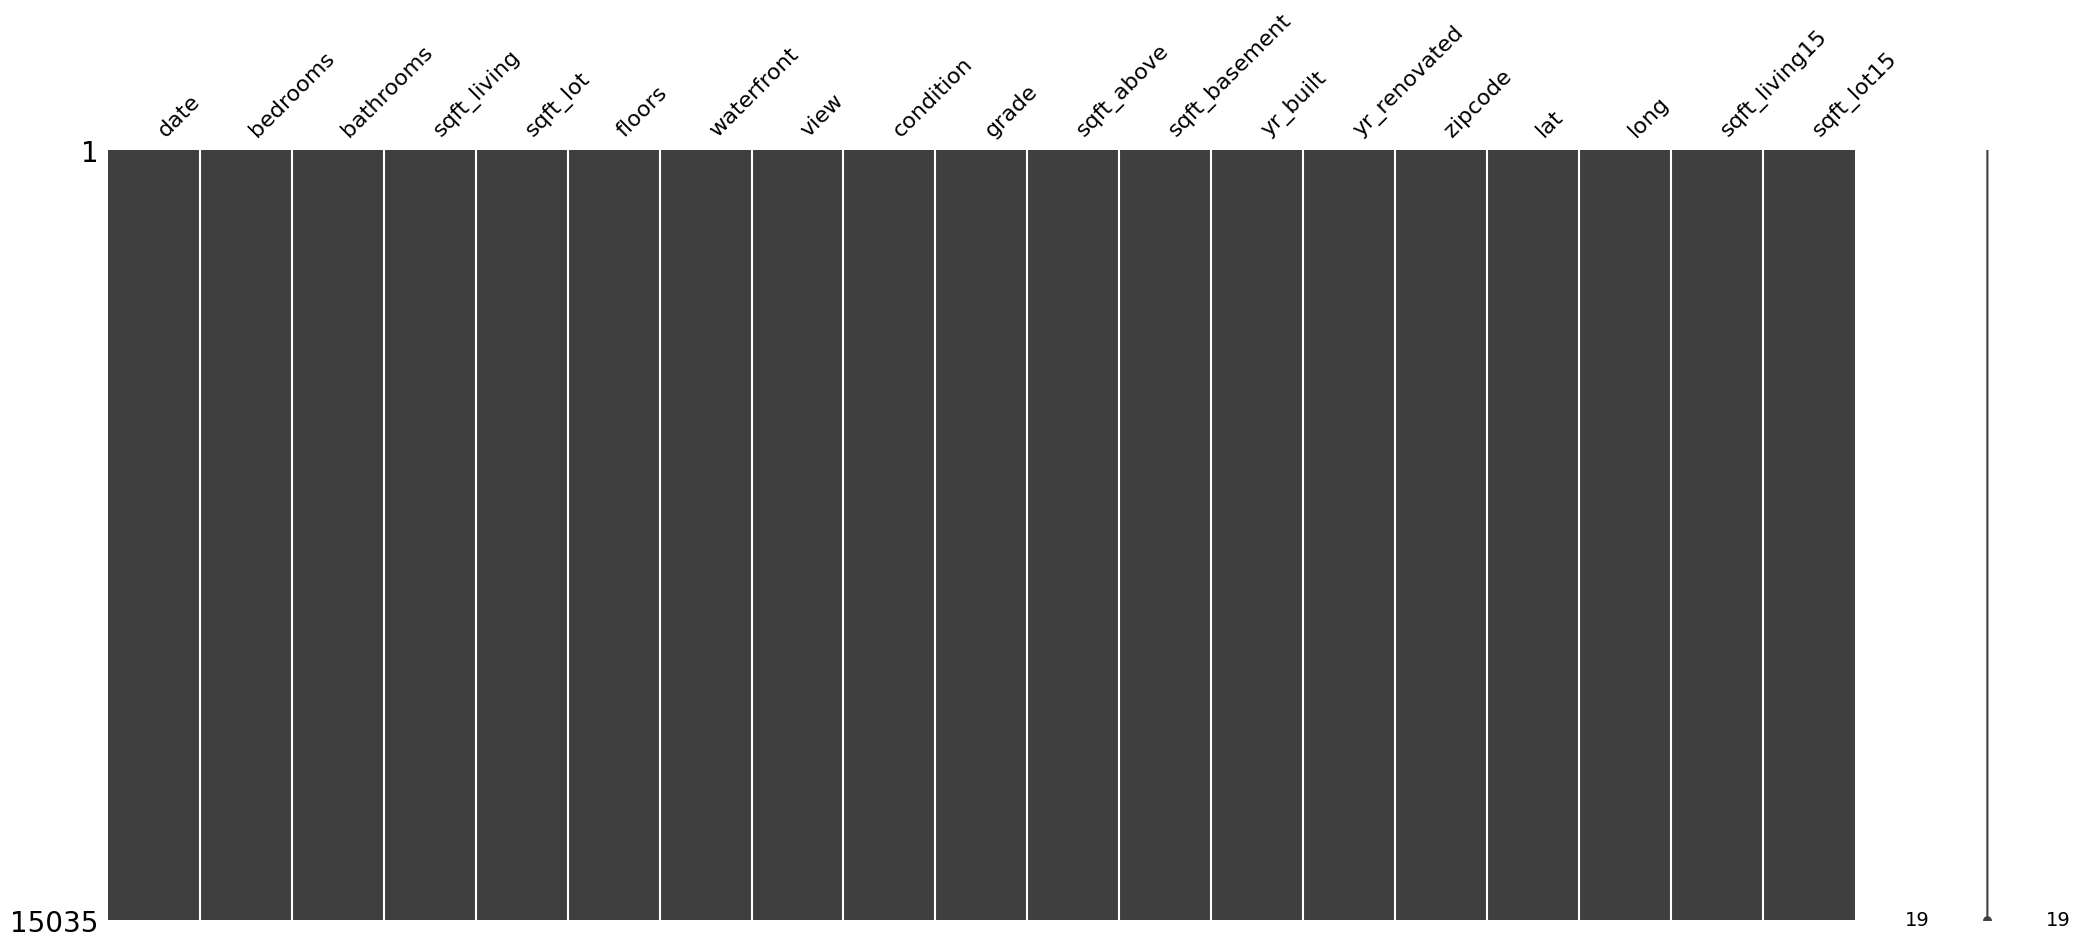

In [215]:
msno.matrix(train)
plt.show()

In [216]:
test.isnull().sum()

date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

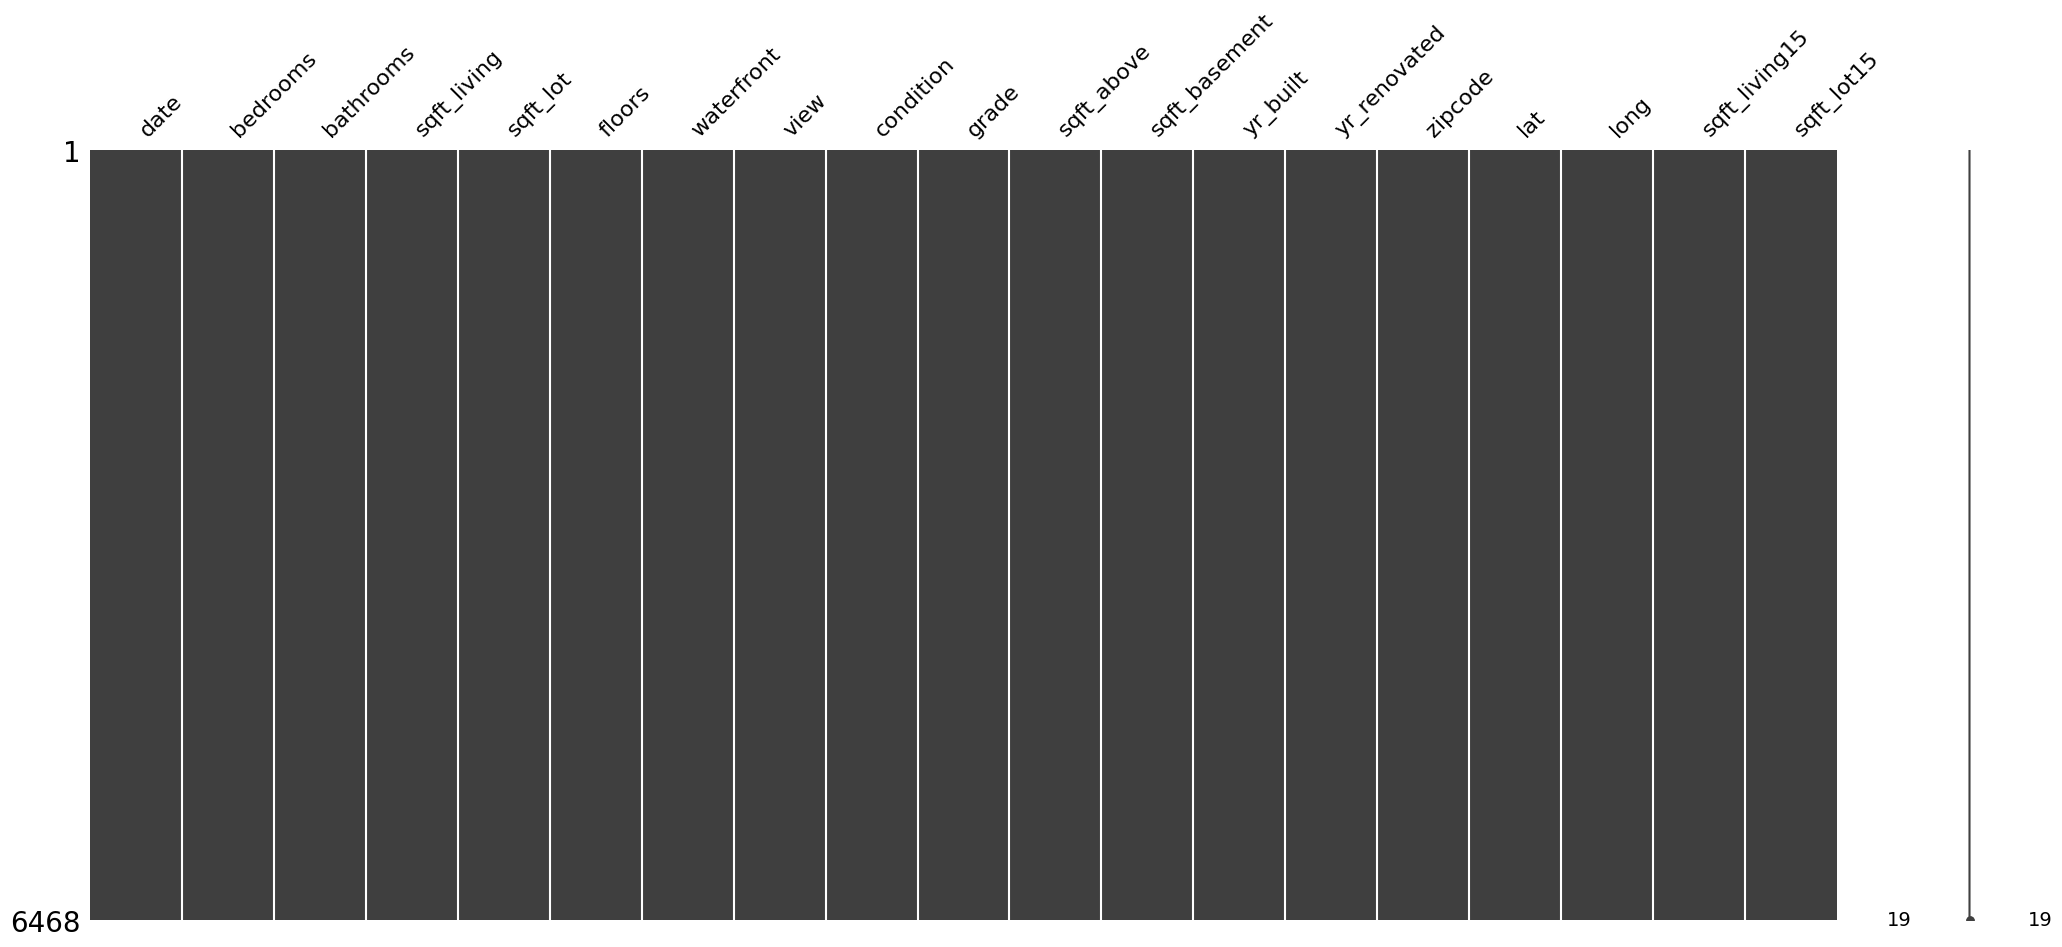

In [217]:
msno.matrix(test)
plt.show()

In [218]:
target_price.isnull().sum()

0

### Date값 년월로 정리  


In [219]:
train['date'] = train['date'].apply(lambda x : x[: 6]).astype(int)
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [220]:
test['date'] = test['date'].apply(lambda x : x[: 6]).astype(int)
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


#### 시각화 : Plot 그래프

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64


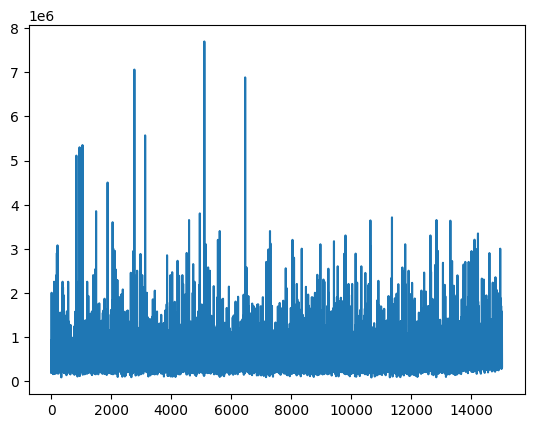

In [221]:
print(target_price)
plt.plot(target_price)
plt.show()

#### 시각화 : 커널 밀도 추정 (KDE: Kernel Density Estimator) 그래프

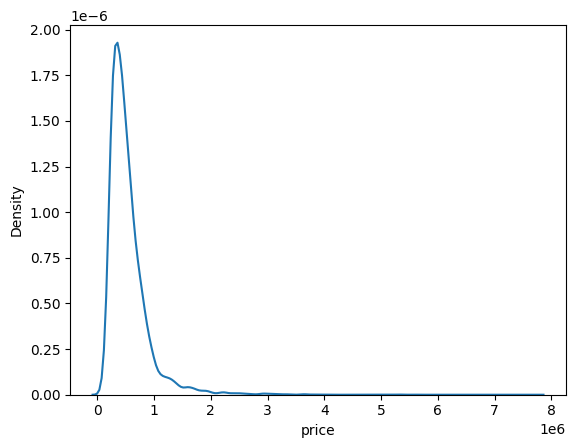

In [222]:
sns.kdeplot(target_price)
plt.show()

데이터로 차트를 그릴 때 일반적인 그래프만으로는 분포도가 안보이는 한계가 있는것을 위 그래프로 알게 됐으며,  
seaborn 라이브러리의 데이터 분포를 확인하는 커널 밀도 추정(KDE: Kernel Density Estimator) 플롯을 이용하여  
데이터 분포도를 확인했습니다. (데이터가 x축의 0~1 사이로 치우쳐져 있음을 확인)  
  
[[seaborn]커널밀도추정 KDE](https://hleecaster.com/python-seaborn-kdeplot/)

### 한쪽으로 치우쳐진 target값 분산

In [223]:
log_target_price = np.log1p(target_price)
log_target_price

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

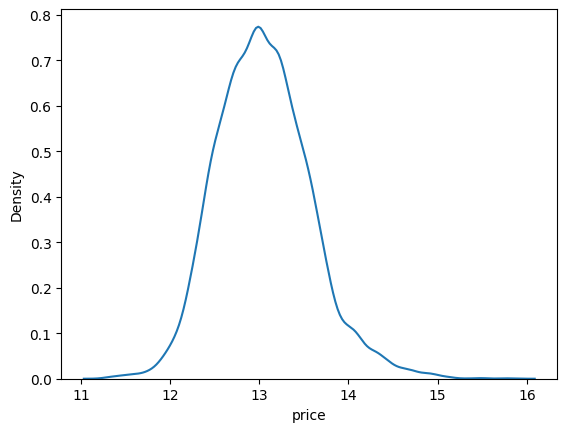

In [224]:
sns.kdeplot(log_target_price)
plt.show()

### 데이터 전처리 종료  


1. 데이터 내용 확인(columns, values 등)
2. Price 를 target 으로 지정
3. train 에 포함된 target (Price) del 처리
4. 데이터들의 결측치 파악 및 시각화 (data.isnull().sum() & msno.matrix())
5. train 과 test 데이터의 Date 값 정리 및 시각화
6. target(Price) 데이터의 분포도 시각화 및 분산작업(log 작업)  


### RMSE 계산식  


In [225]:
y = log_target_price

def rmse(y_test, y_pred):
    return mean_squared_error(np.expm1(y_test), np.expm1(y_pred)) ** 0.5

현재 target 데이터는 분산작업을 위해 log1p()함수를 이용하여 원하는  
target 데이터와는 다른 데이터인 상태이므로 expm1()함수를 이용하여  
기존 데이터상태로 원복시켜 RMSE 로 계산할 수 있게끔 진행  
MSE = ((a - b) ** 2).mean()  
RMSE = MSE ** 0.5  
np.sqrt() == ** 0.5  

### 모델 객체 생성

In [226]:
g_boost = GradientBoostingRegressor(random_state = 5959)
xg_boost = XGBRegressor(random_state = 5959)
light_gbm = LGBMRegressor(random_state = 5959)
rdforest = RandomForestRegressor(random_state = 5959)

models = [g_boost, xg_boost, light_gbm, rdforest]
# 여러가지 모델 한번에 학습 및 예측 시키기 위해 list 로 mapping 진행

### 모델 학습 및 예측

In [227]:
model_rmse = {} # 모델의 예측값에 RMSE 값 대입

for model in models:
    model_name = model.__class__.__name__ # models list의 모델 이름을 가져옴
    
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.2, random_state = 5959)

    model.fit(X_train, y_train) # 학습
    y_pred = model.predict(X_test) # 예측
    model_rmse[model_name] = rmse(y_test, y_pred) # RMSE 값을 계산 후 모델명과 계산값 dictionary 값에 추가

    df_score = pd.DataFrame(model_rmse, index = ['RMSE'])

model_rmse

{'GradientBoostingRegressor': 141453.6639466595,
 'XGBRegressor': 115676.70744765547,
 'LGBMRegressor': 121173.14422136603,
 'RandomForestRegressor': 136630.73310519254}

### 모델에 따른 점수 계산식 함수로 정리

In [228]:
def scores(models, train, y):
    model_rmse = {} # 모델의 예측값에 RMSE 값 대입

    for model in models:
        model_name = model.__class__.__name__ # models list의 모델 이름을 가져옴
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.2, random_state = 5959)

        model.fit(X_train, y_train) # 학습
        y_pred = model.predict(X_test) # 예측
        model_rmse[model_name] = rmse(y_test, y_pred) # RMSE 값을 계산 후 모델명과 계산값 dictionary 값에 추가

        df_score = pd.DataFrame(model_rmse, index = ['RMSE']).T.sort_values('RMSE', ascending = False)

    return df_score

In [229]:
scores(models, train, y)

,RMSE
GradientBoostingRegressor,141453.663947
RandomForestRegressor,136630.733105
LGBMRegressor,121173.144221
XGBRegressor,115676.707448


### GridSearchCV 를 이용한 하이퍼 파라미터 탐색

GridSearchCV 에 들어가는 인자값 정의 및 모델 준비

In [230]:
param_grid = {'n_estimators' : [50, 100], 'max_depth' : [1, 10]}

model = LGBMRegressor(random_state = 5959)

GridSearchCV 를 이용해 grid_model 을 초기화 후 학습

In [231]:
grid_model = GridSearchCV(model, param_grid = param_grid,
                        scoring = 'neg_mean_squared_error',
                        cv = 5, verbose = 1, n_jobs = 5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=5959), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

위 학습한 내용은 grid_model.cv_results_ 으로 저장

In [232]:
grid_model.cv_results_

{'mean_fit_time': array([0.07849178, 0.11571946, 0.19633541, 0.32639303]),
 'std_fit_time': array([0.00419182, 0.00551892, 0.00377067, 0.01597036]),
 'mean_score_time': array([0.00565348, 0.00977368, 0.01588445, 0.02820621]),
 'std_score_time': array([0.00110744, 0.00095341, 0.00078611, 0.00252581]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

인자로 지정했던 max_depth, n_estimators 가 들어간 params 에 대한 정보 추출

In [233]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

각각의 테스트 평균점수 추출(mean_test_score)

In [234]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

### 데이터프레임으로 내용 정리

In [235]:
df_grid = pd.DataFrame(params)
df_grid['score'] = score

df_grid

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


score 값이 음수인 이유 : grid_model 을 초기화할 때 scoring 인자로 neg_mean_squared_error 를 사용  
현재 데이터는 Regression (회귀) 문제를 다루고 있기에 Regression 에 대한 scoring 을 사용

### RMSE 값 확인(scoring에 대한 인자로는 MSE 값을 확인 - neg_mean_squared_error)

음수로 된 데이터 양수로 전환 및 RMSE 에 대한 수식 - np.sqrt(= ** 0.5) 입력

In [236]:
df_grid['RMSLE'] = (-1 * df_grid['score']) ** 0.5

df_grid

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


RMSLE 로 columns 를 지정한 이유는 기존 데이터를 log 함수로 변환하여 데이터를 분산시켜 확인했으며  
grid 를 이용한 탐색이 아닌 일반 RMSE 를 구하는 값에선 np.expm1() 함수로 원복시켜 확인했었으나  
grid 에선 np.expm1() 함수를 사용하질 않아 log 함수로 변환된 데이터를 그대로 사용하여 RMSE 를 구함  
정확히 이는 RMSE 가 아닌 RMSLE 값이라 부름(Root Mean Squared Log Error)

### RMSLE 값 정렬

In [237]:
df_grid = df_grid.sort_values('RMSLE')

df_grid

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


### GridSearchCV 를 함수로서 정의

In [238]:
# return 값은 df_grid 이며 score 확인은 df_grid 로 확인
def gridsearch_m(model, train, y, param_grid, verbose = 2, n_jobs = 5):
    
    # grid_model 초기화
    grid_model = GridSearchCV(model, param_grid = param_grid, scoring = 'neg_mean_squared_error',
                            cv = 5, verbose = verbose, n_jobs = n_jobs)
    
    # grid_model 학습
    grid_model.fit(train, y)

    # params_grid 로 지정한 하이퍼 파라미터에 대한 내용과 score 값 변수로 정의
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # DataFrame 으로 prams_grid 값과 그에 따른 score 값 확인
    df_grid_t = pd.DataFrame(params)
    df_grid_t['score'] = score

    # score 값은 현재 MSE 값이므로 RMSLE 값으로 변환(값의 양전도 같이 진행) 및 RMSLE 값 정렬 진행(sort 함수)
    df_grid_t['RMSLE'] = (-1 * df_grid_t['score']) ** 0.5
    df_grid_t = df_grid_t.sort_values('RMSLE')
    
    return df_grid_t

### GridSearchCV 함수를 이용한 하이퍼 파라미터값 확인

In [239]:
param_grid = {'n_estimators' : [50, 100], 'max_depth' : [1, 10]}

model = LGBMRegressor(random_state = 5959)
print(gridsearch_m(model, train, y, param_grid))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
   max_depth  n_estimators     score     RMSLE
3         10           100 -0.027027  0.164399
2         10            50 -0.029177  0.170814
1          1           100 -0.055020  0.234564
0          1            50 -0.073394  0.270914


df_grid 변수로 return 값을 지정했으므로 data에 대한 score 를 확인하려면 df_grid 값을 호출해야 확인 가능  
RMSLE 값이 가장 이상적인 하이퍼 파라미터값은 max_depth = 10, n_estimators = 100 값으로 확인  

### 확인된 가장 이상적인 값을 가지고 모델 재정의

In [240]:
model = LGBMRegressor(max_depth = 10, n_estimators = 100, random_state = 5959)
model.fit(train, y)
pred_y = model.predict(test)

pred_y

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

현재 사용중인 데이터 y 는 log 함수로 재정의된 데이터로 실제 값을 확인하려면 np.expm1() 함수로 재정의하여  
값을 재확인할 필요가 있어보임

In [241]:
pred_y = np.expm1(pred_y)

pred_y

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

### 캐글에 제출할 sample_submission.csv 파일 head 확인

In [242]:
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


### 제출할 price 값에 모델이 예측한 값을 덮어씌우기

In [243]:
submission['price'] = pred_y

submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


### 데이터 저장(모델별 데이터)

In [244]:
submission_csv_path = price_path + '/test_model/{0}_RMSLE_{1}.csv'.format('lgbm', '0.164399')
submission.to_csv(submission_csv_path, index = False)
print(submission_csv_path)

\Users\ASUS/Desktop/python/exploration/exploration_11_08/data/test_model/lgbm_RMSLE_0.164399.csv


### 여러 테스트를 진행 후 저장을 위해 저장 함수로 재정의

In [245]:
def save(model, train, y, test, model_name, rmsle = None):

    model.fit(train, y)
    pred_y = model.predict(test)
    pred_y = np.expm1(pred_y)
    price_path = os.getenv('homepath') + '/Desktop/python/exploration/exploration_11_08/data'
    submission = pd.read_csv(price_path + '/sample_submission.csv')
    submission['price'] = pred_y
    submission_csv_path = price_path + '/test_model/{0}_RMSLE_{1}.csv'.format(model_name, rmsle)
    submission.to_csv(submission_csv_path, index = False)
    print('{0} saved complite'.format(submission_csv_path))

## 각종 모델에 대한 하이퍼 파라미터 값 찾기

### RandomForest

In [246]:
model = rdforest

param_grid = {'n_estimators' : [10, 100], 
              'max_depth' : [5, 10, 15, 20], 
              'min_samples_split' : [10, 15, 20],
              'min_samples_leaf' : [10, 15, 20]}

print(gridsearch_m(model, train, y, param_grid))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
    max_depth  min_samples_leaf  min_samples_split  n_estimators     score  \
55         20                10                 10           100 -0.034864   
57         20                10                 15           100 -0.034864   
59         20                10                 20           100 -0.034864   
37         15                10                 10           100 -0.034908   
41         15                10                 20           100 -0.034908   
..        ...               ...                ...           ...       ...   
10          5                15                 20            10 -0.059510   
6           5                15                 10            10 -0.059510   
14          5                20                 15            10 -0.059572   
16          5                20                 20            10 -0.059572   
12          5                20                 10            10 -0.059572   

 

### GradientBoostingRegressor

In [247]:
model = g_boost

param_grid = {'n_estimators' : [100, 300, 500], 
              'learning_rate' : [0.1, 0.05, 0.01, 0.005]}

print(gridsearch_m(model, train, y, param_grid))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
    learning_rate  n_estimators     score     RMSLE
2           0.100           500 -0.027522  0.165898
1           0.100           300 -0.028622  0.169180
5           0.050           500 -0.029145  0.170718
4           0.050           300 -0.031198  0.176630
0           0.100           100 -0.033393  0.182738
3           0.050           100 -0.039733  0.199332
8           0.010           500 -0.039851  0.199626
7           0.010           300 -0.049158  0.221716
11          0.005           500 -0.054519  0.233492
10          0.005           300 -0.076616  0.276796
6           0.010           100 -0.102407  0.320012
9           0.005           100 -0.156295  0.395342


### XGBRegressor

In [249]:
model = xg_boost

param_grid = {'eta' : [0.7, 1],
              'max_depth' : [3, 5, 10],
              'colsample_bytree' : [0.5, 1]}

print(gridsearch_m(model, train, y, param_grid))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
    colsample_bytree  eta  max_depth     score     RMSLE
1                0.5  0.7          5 -0.028266  0.168126
4                0.5  1.0          5 -0.028266  0.168126
7                1.0  0.7          5 -0.028401  0.168527
10               1.0  1.0          5 -0.028401  0.168527
6                1.0  0.7          3 -0.029927  0.172994
9                1.0  1.0          3 -0.029927  0.172994
0                0.5  0.7          3 -0.029985  0.173161
3                0.5  1.0          3 -0.029985  0.173161
2                0.5  0.7         10 -0.030447  0.174490
5                0.5  1.0         10 -0.030447  0.174490
8                1.0  0.7         10 -0.030600  0.174930
11               1.0  1.0         10 -0.030600  0.174930


LGBM = 0.164399  
XGB = 0.168126  
GBM = 0.169180  
RandomForest = 0.186719  
  

제일 결과값이 좋은 LGBM 으로 캐글 My submission 제출 진행

## 회고

이번 프로젝트에선 하이퍼파라미터를 다루는 프로젝트를 진행한것으로 확인되었으며  
여러가지 모델에 대해서 튜닝을 직접 해보고 결과값을 얻을 수 있는 프로젝트로  
여러가지 모델에 대한 실험을 해볼 수 있어서 실질적으로 배운것을 직접 써볼 수 있었던 프로젝트 였습니다.  
  
매번 아쉬웠지만 이번에도 아쉬웠던점이 있다면 여러가지 실험을 해봤음에도 불구하고  
하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻지 못한것이  
아쉬웠으며 조금이라도 시간이 더 있었다면 하이퍼 파라미터 튜닝 뿐만이 아닌 피처 엔지니어링도 직접 해봄으로서  
좀 더 좋은 점수 결과를 얻을 수 있었지 않았을까 싶은 프로젝트입니다.  
  
1. 프로젝트를 진행하며 여러가지 모델을 하이퍼파라미터로 튜닝 해보면서 진행해본 결과  
각각의 LGBM = 0.164399 / XGB = 0.168126 / GBM = 0.169180 / RandomForest = 0.186719 RMSLE 값을 도출했는데  
노드내용에 나온 LGBM의 튜닝값이 가장 최적의 값으로 나왔던 부분이 가장 아쉬운 부분이었습니다.  
위 모델 중 여러가지 튜닝 시도를 해보고 가장 많이 변경했었던 모델은 XGB 모델로 일반적인 RMSE 값이 가장 최적의 값으로  
나와 여러가지 시도를 해봤으나 한계점은 0.168126의 값이었으며.. LGBM의 모델보다 아쉽게 나온것은  
이번 프로젝트 이후 개인적인 시간을 내서 재튜닝 후에 가장 최적의 값을 찾아보려 계획을 하고 있습니다.  
  
이번 프로젝트는 프로젝트 이후의 목표가 처음으로 생겼던 프로젝트였으며 직접 찾아보며 여러가지를 시도해보고  
가장 많이 테스트 해봤었던 프로젝트로 하이퍼 파라미터 튜닝에 대해서 좀 더 자세하게 와닿을 수 있었습니다.

## 참고문헌 Reference  

[[seaborn]커널밀도추정 KDE](https://hleecaster.com/python-seaborn-kdeplot/)  
[로그변환과 np.log()가 아닌 np.log1p()를 하는 이유](https://suppppppp.github.io/posts/Why-Series-MDM-1/)  
[결측치/결측값 시각화하는 5가지 방법](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=youji4ever&logNo=221623491491)  
[3.3.1. The scoring parameter: defining model evaluation rules](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)  
[[Chapter 4. 분류] 랜덤포레스트(Random Forest)](https://injo.tistory.com/30)  
[[Chapter 4. 분류] 부스팅알고리즘(AdaBoost, GBM)](https://injo.tistory.com/31)  
[XGboost 주요 하이퍼파라미터](https://zzinnam.tistory.com/entry/XGboost-%EC%A3%BC%EC%9A%94-%ED%95%98%EC%9D%B4%ED%8D%BC%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-with-%ED%8C%8C%EC%9D%B4%EC%8D%AC)  
exploration 3번 노드  

  
Error 해결  
  
[Typeerror: 유형 개체를 첨자할 수 없습니다( 수정 단계)](https://www.datasciencelearner.com/typeerror-type-object-is-not-subscriptable-fix/)  
[typeError:'tuple' object is not callable 해결](https://blog.naver.com/PostView.naver?blogId=jaeyoon_95&logNo=222113266764&categoryNo=94&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=search)  

